# Последовательный анализ

In [1]:
!python3 -m pip install sprt

  Preparing metadata (setup.py) ... done
  Created wheel for sprt: filename=sprt-0.0.1-py3-none-any.whl size=4018 sha256=1fc26f97ae061621c3bf5b9f53ece21af1f59fb01b8296e8a043c875829115cf
  Stored in directory: /root/.cache/pip/wheels/57/4f/5e/0ccefece378c1aac79f5e3093849173236b19f3781e070ab03
Successfully built sprt


## Библиотеки

In [2]:
import numpy as np
import sprt
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt

## Warmup

### Генерация данных

- $p_L$ - нижняя граница
- $p_U$ - верхняя граница
- $\alpha$ - уровень значимости, допускаемая вероятность ошибки первого рода: отвергнуть верную $H_0$ (при $p \le p_L$)
- $\beta$ - допускаемая вероятность ошибки второго рода: принять неверную $H_0$ (при $p \ge p_U$)

In [3]:
pl = 0.45
pu = 0.55
alpha = beta = 0.05
A = (1 - beta) / alpha
B = beta / (1 - alpha)

def a_m(m):
    return (np.log(B) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 - pl)))

def r_m(m):
    return (np.log(A) + m * np.log((1 - pl) / (1 - pu))) / (np.log(pu / pl) - np.log((1 - pu) / (1 -pl)))

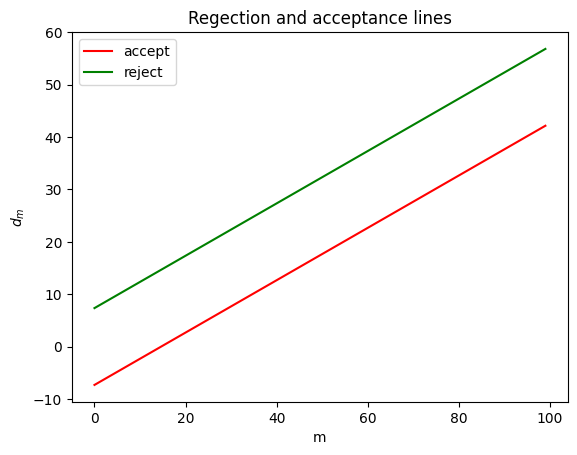

In [4]:
plt.plot(range(100), [a_m(i) for i in range(100)], label='accept', color='red')
plt.plot(range(100), [r_m(i) for i in range(100)], label='reject', color='green')
plt.xlabel('m')
plt.ylabel('$d_m$')
plt.legend(loc='best')

plt.title('Regection and acceptance lines')

plt.show()

### Z-критерий меток для доли (лекция 2: параметрические гипотезы) и последовательный анализ для проверки $p$

Сравним результаты последовательного анализа и z-теста меток для доли

Последовательный анализ:

$H_0:\ p \le p_L$

$H_1:\ p \ge p_U$

Критерий меток доли (левосторонняя альтернатива):

$H_0:\ p = p_0$

$H_1:\ p < p_0$

#### Генерация данных ($Ber(p)$) и проверка z-критерием меток

In [5]:
def generate_and_test(real_p, test_func, maxm=500, seed=42):
    """
    Генерация выборки из бернуллиевских величин, генерация останавливается, когда при последовательном анализе мы отвергаем
    или принимаем H_0 и одновременно то же делает z-test
    :param real_p - p
    :param test_func - функция для проверки z-теста, возвращает p-value
    :param maxm - максимальный размер выборки
    :return полученная выборка, массив p-value, номер первой итерации, где график вышел за пределы полосы
    """
    rs = np.random.RandomState(seed)
    sample = []
    pvals = []
    m = 0
    test_iter_num = -1 # номер итерации, где отвергается гипотеза по z-тесту
    iter_num = -1 # номер итерации, где мы выходим за пределы области безразличия (между двумя accept и reject)
    while m < maxm and (iter_num < 0 or test_iter_num < 0):
        m += 1
        x = rs.uniform() <= real_p
        sample += [x]
        pvals.append(test_func(sample))
        if iter_num < 0 and (np.sum(sample) <= a_m(m) or np.sum(sample) >= r_m(m)):
            iter_num = m

        if pvals[-1] < 0.05:
            test_iter_num = m

    return sample, pvals, iter_num

In [6]:
def plot_seq_ztest_results(sample, bin_test):
    max_l = len(sample)
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(np.cumsum(sample), label='actual d_m')
    ax1.plot(range(max_l), [a_m(i) for i in range(max_l)], label='accept', color='green')
    ax1.plot(range(max_l), [r_m(i) for i in range(max_l)], label='reject', color='red')
    ax1.legend(loc='best')
    ax1.set_xlabel('m')
    ax1.set_ylabel('$d_m$')
    ax1.set_title('Sequential analysis')

    ax2 = fig.add_subplot(122)
    ax2.plot([0, 250], [0.05, 0.05])
    ax2.plot(bin_test)
    ax2.set_xlabel('m')
    ax2.set_ylabel('p-value')
    ax2.set_title('Z-tests')

#### $p=0.4$

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


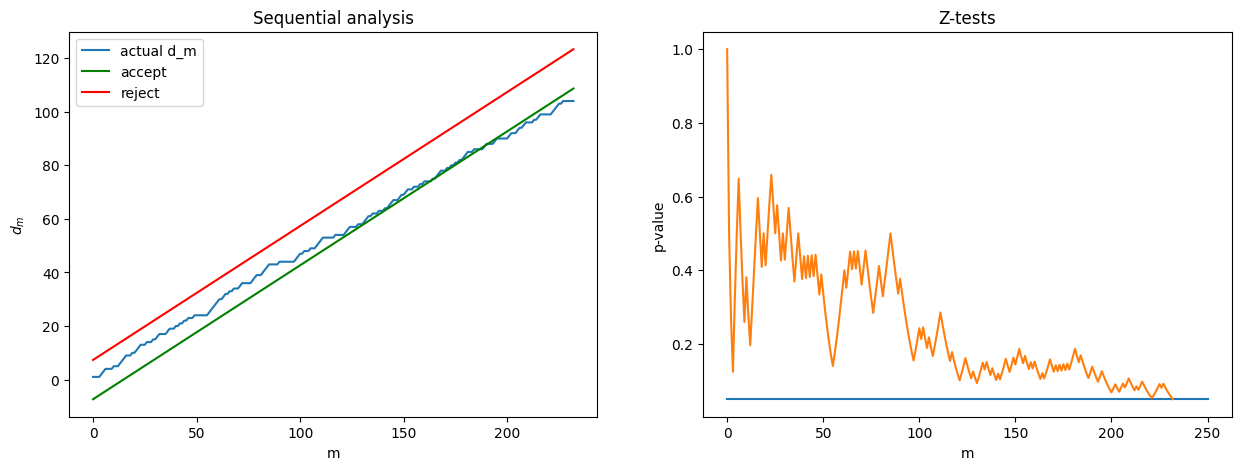

In [7]:
sample, bin_test, _ = generate_and_test(0.4, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1])
plot_seq_ztest_results(sample, bin_test)

#### $p=0.6$

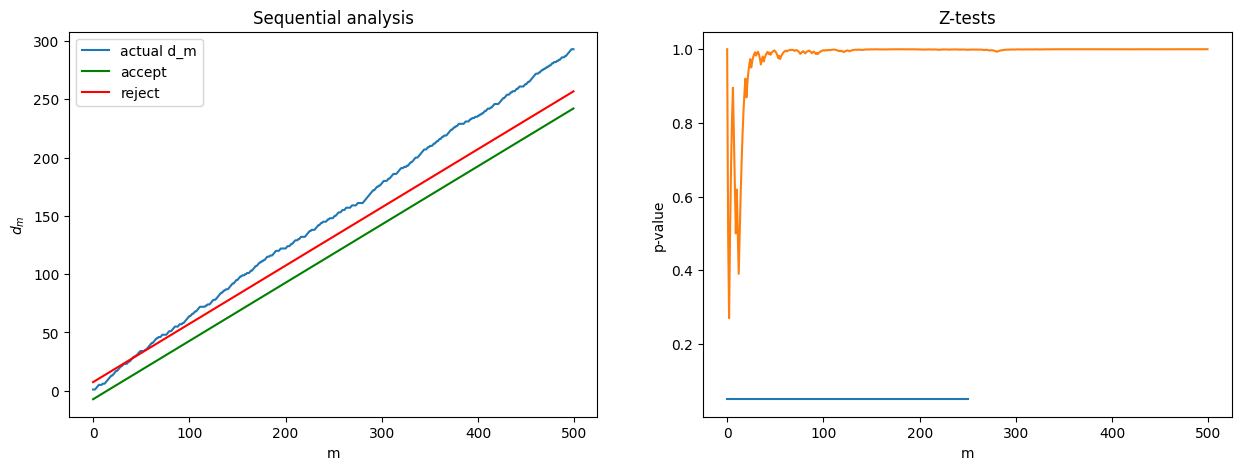

In [8]:
sample, bin_test, _ = generate_and_test(0.6, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1])
plot_seq_ztest_results(sample, bin_test)

#### $p=0.5$

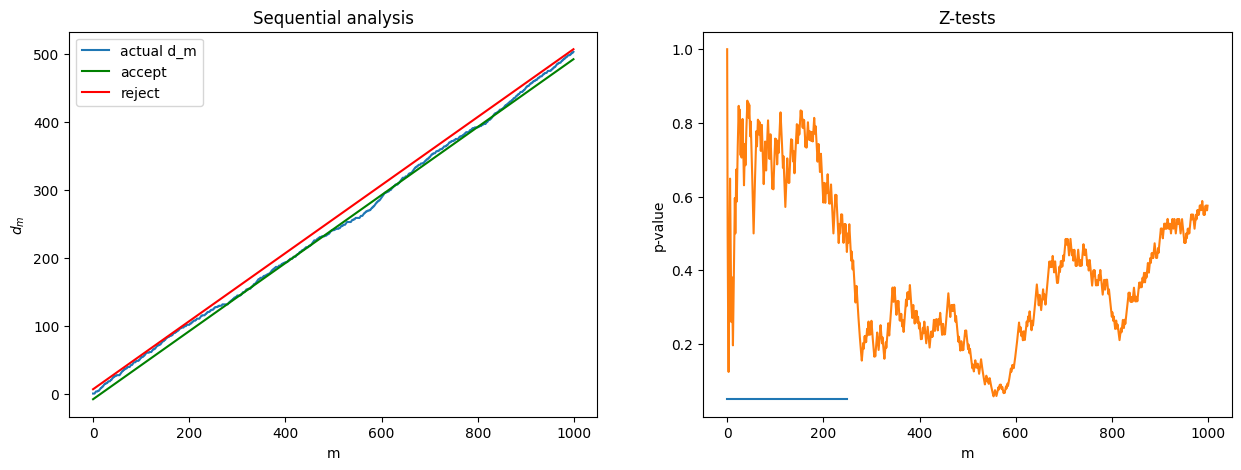

In [9]:
sample, bin_test, _ = generate_and_test(0.5, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller')[1], maxm=1000)
plot_seq_ztest_results(sample, bin_test)

#### Рассмотрим разный random_state

379


Text(0, 0.5, 'p-value')

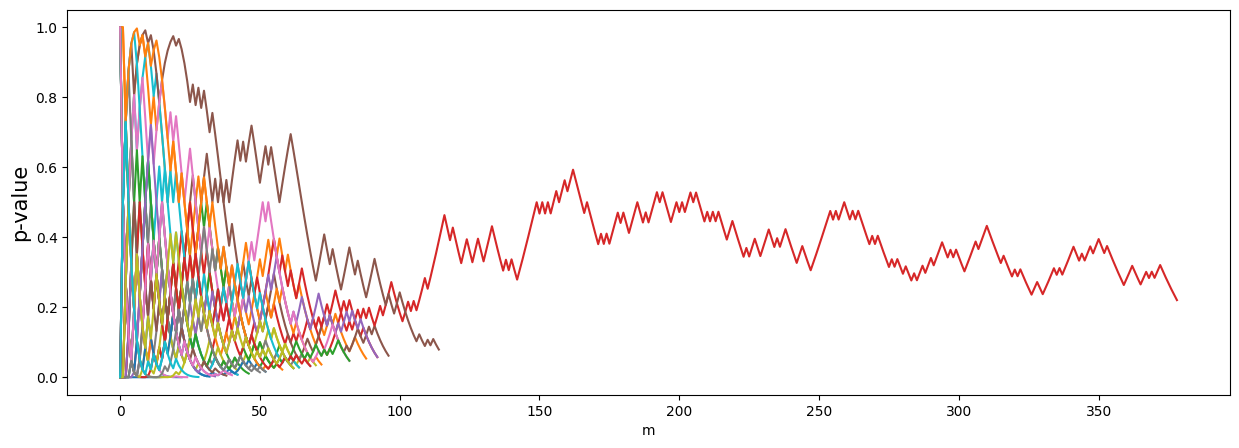

In [10]:
max_l = 0
bin_tests = []
iter_nums = []
for i in range(30):
    sample_, bin_test, iter_num = generate_and_test(0.4, seed=i, test_func=lambda x: proportions_ztest(np.sum(x), len(x), 0.5, 'smaller' )[1])
    max_l_ = len(sample_)
    max_l = max(max_l_, max_l)
    iter_nums.append(iter_num)
    bin_tests.append(bin_test)
print(max_l)

plt.figure(figsize=(15, 5))
for t in bin_tests:
    plt.plot(t)
plt.xlabel('m')
plt.ylabel('p-value', fontdict={'size': 15})

#### Разница в размерах итоговых выборок

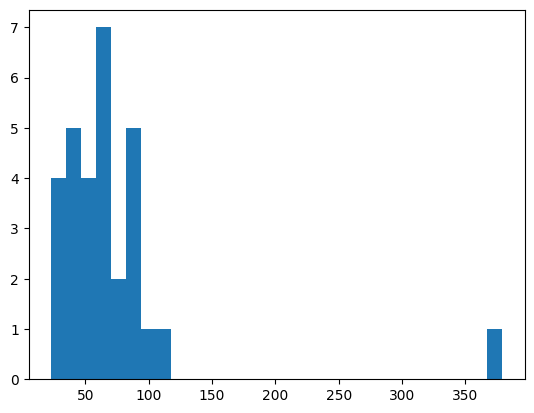

In [11]:
min_num = []
for p in bin_tests:
    min_num.append(np.where(np.array(p) <= 0.05)[0][0])
min_num = np.array(min_num)
plt.hist(np.array(iter_nums), bins=30)

plt.show()

#### Последовательный тест Вальда из коробки
- $h_0 == H_0$
- $h_1 == H_1$

Decision:	Accept

     values    lower    upper
n                            
491     236  238.164  252.836
492     236  238.664  253.336
493     237  239.164  253.836
494     238  239.664  254.336
495     239  240.164  254.836
496     240  240.664  255.336
497     240  241.164  255.836
498     241  241.664  256.336
499     241  242.164  256.836
500     241  242.664  257.336


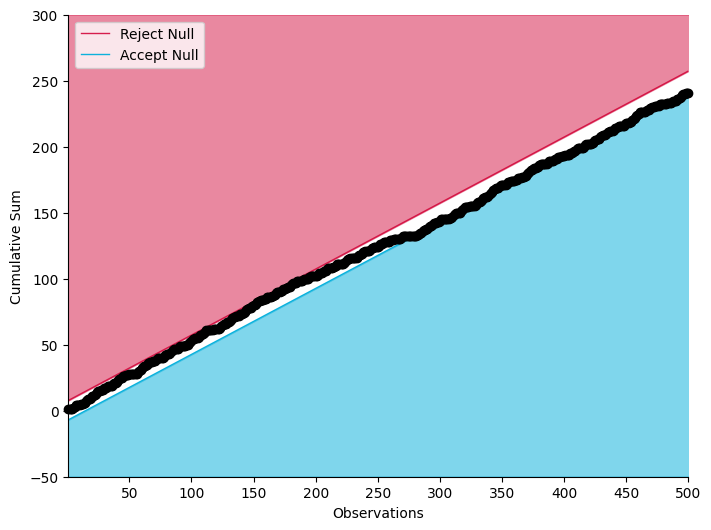

In [12]:
rs = np.random.RandomState(42)
values = rs.uniform(size=500) <= 0.5
test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=0.45, h1=0.55, values=values)
test.plot()

plt.show()

## Метилфенидат и синдром дефицита внимания

24 умственно отсталых ребёнка с СДВГ в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.

Каков эффект препарата?

### Данные

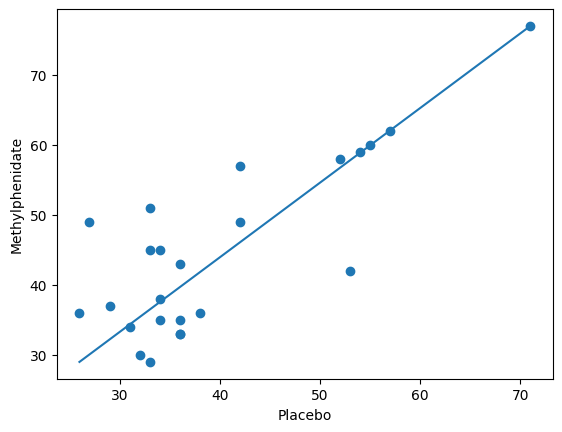

In [13]:
att = np.loadtxt('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem10/data/ADHD.txt', delimiter=' ', skiprows=1)


plt.scatter(att[:, 0], att[:, 1])
plt.xlabel('Placebo')
plt.ylabel('Methylphenidate')
_ = plt.plot([min(att[:,0]), max(att[:,0])], [min(att[:, 1]), max(att[:, 1])])

### Нормальность дельт

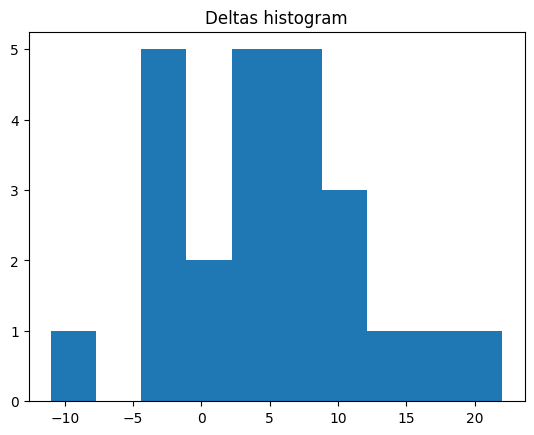

In [14]:
deltas = att[:, 1] - att[:, 0]
plt.hist(deltas)
_ = plt.title('Deltas histogram')

In [15]:
st.shapiro(deltas)

ShapiroResult(statistic=0.9798057675361633, pvalue=0.8922585248947144)

### Последовательный анализ Вальда для нормального распределенияи

Рассмотрим, как меняется коридор безразличия при изменении $\alpha$ и $\beta$ (предполагаем, что дисперсия известна, так как иначе это будет t-тест, а не z-тест).

$H_0: \mu \le \mu_L$

$H_1: \mu \ge \mu_U$

- $p_L$ - нижняя граница
- $p_U$ - верхняя граница
- $\alpha$ - уровень значимости, допускаемая вероятность ошибки первого рода: отвергнуть верную $H_0$ (при $p \le p_L$)
- $\beta$ - допускаемая вероятность ошибки второго рода: принять неверную $H_0$ (при $p \ge p_U$)

In [16]:
mean = np.mean(deltas)
var = np.std(deltas, ddof=1)**2

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -64.045  138.420
16    96.0 -61.566  140.900
17    93.0 -59.087  143.379
18   100.0 -56.608  145.858
19    97.0 -54.129  148.337
20   102.0 -51.650  150.816
21   103.0 -49.170  153.295
22   111.0 -46.691  155.775
23   123.0 -44.212  158.254
24   119.0 -41.733  160.733


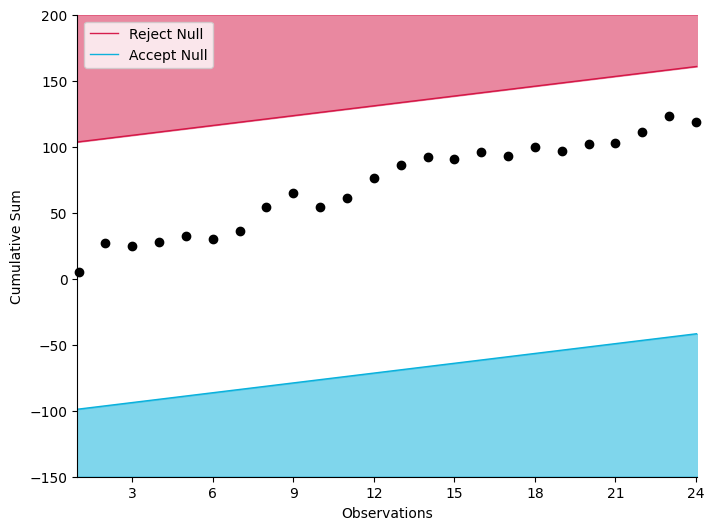

In [17]:
test = sprt.SPRTNormal(alpha=0.05, beta=0.05, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -60.221  100.649
16    96.0 -57.742  103.128
17    93.0 -55.263  105.607
18   100.0 -52.784  108.087
19    97.0 -50.305  110.566
20   102.0 -47.826  113.045
21   103.0 -45.346  115.524
22   111.0 -42.867  118.003
23   123.0 -40.388  120.482
24   119.0 -37.909  122.962


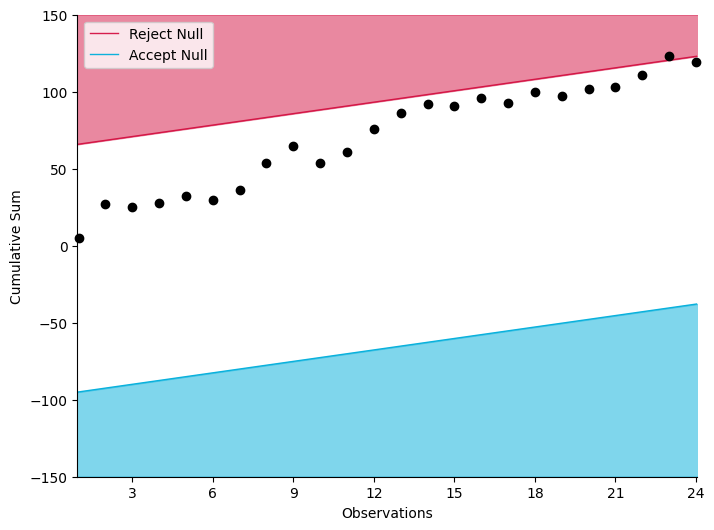

In [18]:
test = sprt.SPRTNormal(alpha=0.15, beta=0.05, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0 -26.274  134.596
16    96.0 -23.795  137.076
17    93.0 -21.316  139.555
18   100.0 -18.837  142.034
19    97.0 -16.357  144.513
20   102.0 -13.878  146.992
21   103.0 -11.399  149.471
22   111.0  -8.920  151.951
23   123.0  -6.441  154.430
24   119.0  -3.962  156.909


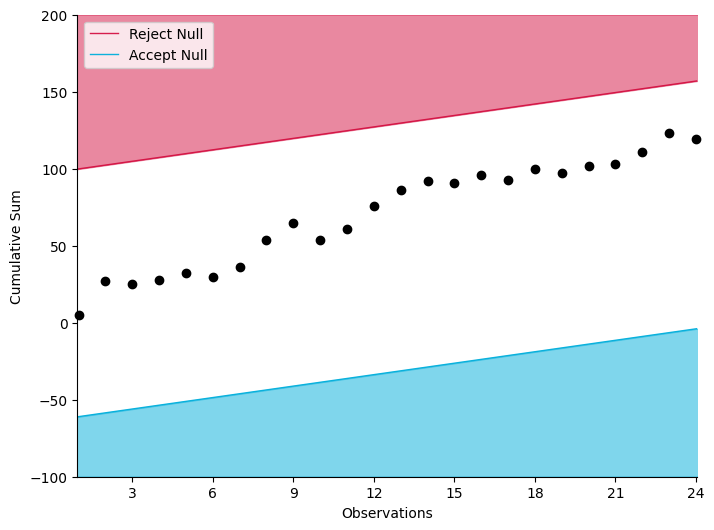

In [19]:
test = sprt.SPRTNormal(alpha=0.05, beta=0.15, h0=mean / 3,  h1=2 * mean / 3, values=deltas, variance=var)
test.plot()

Decision:	Continue

    values   lower    upper
n                          
15    91.0  49.067   99.683
16    96.0  54.025  104.642
17    93.0  58.983  109.600
18   100.0  63.942  114.558
19    97.0  68.900  119.517
20   102.0  73.858  124.475
21   103.0  78.817  129.433
22   111.0  83.775  134.392
23   123.0  88.733  139.350
24   119.0  93.692  144.308


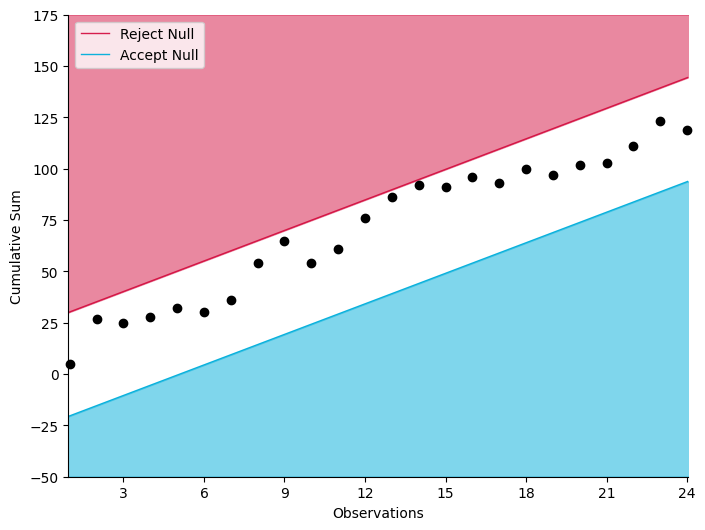

In [20]:
test = sprt.SPRTNormal(alpha=0.05, beta=0.05, h0=mean-mean / 1.5,  h1=mean+mean/1.5, values=deltas, variance=var)
test.plot()